**DICIONARIO DE DADOS**
- **id**: ID de assinante exclusivo.
- **is_tv_subscriber**: se o cliente tem assinatura de TV.
- **is_movie_package_subscriber**: se o cliente tem um pacote de filmes de cinema.
- **subscription_age**: há quantos anos o cliente usa o serviço.
- **bill_avg**: média da fatura dos últimos 3 meses.
- **reamining_contract**: quantos anos restantes para o contrato do cliente. Se **nulo**, o cliente não tem contrato.
- **service_failure_count**: contagem de chamadas de clientes para call center por falha de serviço nos últimos 3 meses.
- **download_avg**: últimos 3 meses de uso de internet (GB).
- **upload_avg**: média de upload dos últimos três meses (GB).
- **download_over_limit**: a maioria dos clientes tem um limite de download. se atingirem esse limite, terão que pagar por isso. Esta coluna contém quantidade acima do limite.
- **churn**: se o cliente deu churn ou não

## SETTINGS

### Download Libraries

In [1]:
!pip install optuna
!pip install xgboost
!pip install lightgbm

### Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 100

### Upload Data Base

In [3]:
df = pd.read_csv('../data/atividade-2-churn-internet.csv')
display(df.info())
display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


None

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1


## DATA PREPROCESSING

### Data Split

In [4]:
df.head(2)

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1


In [5]:
df.isnull().mean()

id                             0.000000
is_tv_subscriber               0.000000
is_movie_package_subscriber    0.000000
subscription_age               0.000000
bill_avg                       0.000000
reamining_contract             0.298475
service_failure_count          0.000000
download_avg                   0.005272
upload_avg                     0.005272
download_over_limit            0.000000
churn                          0.000000
dtype: float64

Como os valores faltantes de **download_avg** e **upload_avg**, são abaixo de 5%, vamos excluí-los do dataframe

In [6]:
df.dropna(subset=['download_avg', 'upload_avg'], inplace=True)

In [7]:
X = df.drop(['churn', 'id'], axis=1)
y = df['churn']

In [8]:
X.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit
0,1,0,11.95,25,0.14,0,8.4,2.3,0
1,0,0,8.22,0,NaN,0,0.0,0.0,0
2,1,0,8.91,16,0.00,0,13.7,0.9,0
3,0,0,6.87,21,NaN,1,0.0,0.0,0
4,0,0,6.39,0,NaN,0,0.0,0.0,0


In [9]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: churn, dtype: int64

In [10]:
#Como não temos desbalanceamento na nossa variável alvo, não precisaremos fazer uso do argumento stratify da função train_test_split() disponível na biblioteca Scikit-learn.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                                                    
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (50325, 9)
X_test: (21568, 9)


In [11]:
print('X_train: {:.1f}'.format(len(X_train)/len(df)))
print('y_train: {:.1f}'.format(len(y_train)/len(df)))
print('X_test: {:.1f}'.format(len(X_test)/len(df)))
print('y_test: {:.1f}'.format(len(y_test)/len(df)))

X_train: 0.7
y_train: 0.7
X_test: 0.3
y_test: 0.3


### Data Preparation

In [12]:
X_train.isnull().mean()

is_tv_subscriber               0.000000
is_movie_package_subscriber    0.000000
subscription_age               0.000000
bill_avg                       0.000000
reamining_contract             0.297089
service_failure_count          0.000000
download_avg                   0.000000
upload_avg                     0.000000
download_over_limit            0.000000
dtype: float64

In [13]:
X_test.isnull().mean()

is_tv_subscriber               0.000000
is_movie_package_subscriber    0.000000
subscription_age               0.000000
bill_avg                       0.000000
reamining_contract             0.304479
service_failure_count          0.000000
download_avg                   0.000000
upload_avg                     0.000000
download_over_limit            0.000000
dtype: float64

Os valore nulos de **download_avg** e **upload_avg** serão excluídos, já os valores faltantes de **reamining_contract** necessitarão de um tratamento melhor, vamos criar uma nova coluna cahamada **reamining_contract_cat**, nela teremos os valores distribuídos em 4 categorias (os quantis) e os que não possuem contrato, serão classificados e uma nova categoria  **no_contract**.                

In [14]:
def process_remaining_contract(data):
    data['reamining_contract_cat'] = pd.cut(data['reamining_contract'], 
                                           bins=[-float('inf'), data['reamining_contract'].quantile(0.25),
                                                 data['reamining_contract'].quantile(0.5),
                                                 data['reamining_contract'].quantile(0.75), float('inf')],
                                           labels=['Q1', 'Q2', 'Q3', 'Q4'], include_lowest=True)
    
    data['reamining_contract_cat'] = data['reamining_contract_cat'].cat.add_categories('no_contract')
    data['reamining_contract_cat'].fillna('no_contract', inplace=True)
    data.drop('reamining_contract', axis=1, inplace=True)
    return data

In [15]:
# def process_remaining_contract(data):
#     data['reamining_contract_cat'] = pd.cut(data['reamining_contract'], 
#                                            bins=[-float('inf'), data['reamining_contract'].quantile(0.25),
#                                                  data['reamining_contract'].quantile(0.5),
#                                                  data['reamining_contract'].quantile(0.75), float('inf')],
#                                            labels=['Q1', 'Q2', 'Q3', 'Q4'], include_lowest=True)
#     data['reamining_contract_cat'] = data['reamining_contract_cat'].cat.add_categories('no_contract')
#     data['reamining_contract_cat'].fillna('no_contract', inplace=True)
#     data.drop('reamining_contract', axis=1, inplace=True)
#     return data

In [16]:
X_train = process_remaining_contract(X_train)
X_train.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,reamining_contract_cat
3088,1,0,5.84,10,1,0.0,0.0,0,no_contract
46248,1,1,2.59,15,0,209.7,15.9,0,Q4
61539,1,0,0.93,13,0,22.2,1.2,0,Q3
21901,1,0,0.10,9,0,0.0,0.0,0,Q2
45193,1,0,1.97,21,2,57.6,6.3,0,Q1


In [17]:
X_test = process_remaining_contract(X_test)
X_test.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,reamining_contract_cat
50375,1,1,2.08,18,0,106.3,14.2,0,Q4
32250,0,0,4.38,19,0,23.8,7.6,0,Q4
35894,0,0,0.21,14,0,5.0,0.3,0,no_contract
61853,1,0,0.25,12,0,31.0,4.9,0,Q1
35774,1,1,4.11,18,2,120.9,5.4,0,Q4


In [18]:
X_train.isnull().mean()

is_tv_subscriber               0.0
is_movie_package_subscriber    0.0
subscription_age               0.0
bill_avg                       0.0
service_failure_count          0.0
download_avg                   0.0
upload_avg                     0.0
download_over_limit            0.0
reamining_contract_cat         0.0
dtype: float64

In [19]:
X_test.isnull().mean()

is_tv_subscriber               0.0
is_movie_package_subscriber    0.0
subscription_age               0.0
bill_avg                       0.0
service_failure_count          0.0
download_avg                   0.0
upload_avg                     0.0
download_over_limit            0.0
reamining_contract_cat         0.0
dtype: float64

In [20]:
numeric_cols = ['subscription_age', 'bill_avg', 'service_failure_count', 'download_avg', 'upload_avg']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [21]:
categorical_cols = ['is_tv_subscriber', 'is_movie_package_subscriber', 'download_over_limit', 'reamining_contract_cat']
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ])

## MODELING

### Logistic Regression

In [23]:
pipeline_lg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('lg', LogisticRegression(solver='liblinear'))])

In [24]:
def objective(trial):
    params = {
        'lg__C': trial.suggest_float('lg__C', 1e-3, 1e2),
        'lg__penalty': trial.suggest_categorical('lg__penalty', ['l2', 'l1']),
       #'lg_class_weight': triel.suggest_float('lg_class_weight', )
    }
    pipeline_lg.set_params(**params)
    cv_scores = cross_val_score(pipeline_lg, X_train, y_train, cv=5)
    return cv_scores.mean() 

[I 2023-09-04 10:43:25,559] A new study created in memory with name: no-name-6d5ee2fe-f528-4bc7-9ebe-259649134886
[I 2023-09-04 10:43:26,377] Trial 0 finished with value: 0.922762046696473 and parameters: {'lg__C': 56.27205918298689, 'lg__penalty': 'l1'}. Best is trial 0 with value: 0.922762046696473.
[I 2023-09-04 10:43:28,426] Trial 1 finished with value: 0.922762046696473 and parameters: {'lg__C': 63.63356981104344, 'lg__penalty': 'l2'}. Best is trial 0 with value: 0.922762046696473.
[I 2023-09-04 10:43:29,294] Trial 2 finished with value: 0.922762046696473 and parameters: {'lg__C': 66.5196299595858, 'lg__penalty': 'l1'}. Best is trial 0 with value: 0.922762046696473.
[I 2023-09-04 10:43:30,170] Trial 3 finished with value: 0.922762046696473 and parameters: {'lg__C': 94.3752196810988, 'lg__penalty': 'l1'}. Best is trial 0 with value: 0.922762046696473.
[I 2023-09-04 10:43:31,057] Trial 4 finished with value: 0.92274217585693 and parameters: {'lg__C': 72.46063639267105, 'lg__penalty'

Acurácia do modelo: 0.92
ROC-AUC do modelo: 0.96
Matriz de Confusão:
[[ 8878   541]
 [ 1103 11046]]


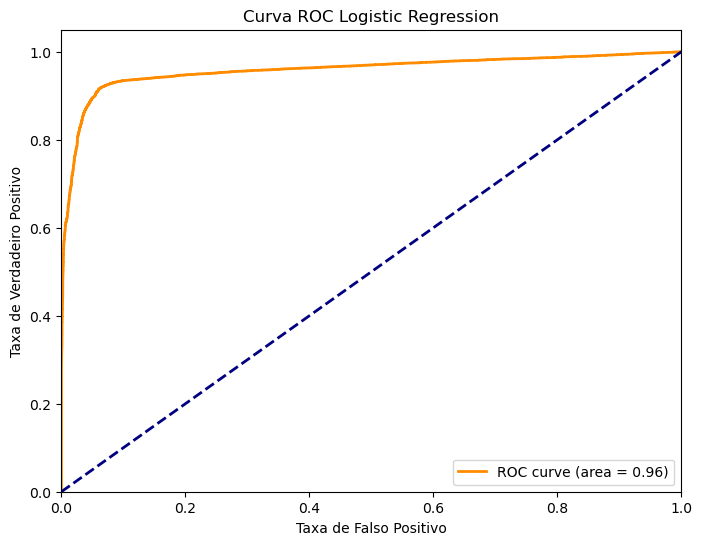

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50) 
best_params = study.best_params

pipeline_lg.set_params(**best_params)
pipeline_lg.fit(X_train, y_train)

y_pred_lg = pipeline_lg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lg)
print(f'Acurácia do modelo: {accuracy:.2f}')

y_prob_lg = pipeline_lg.predict_proba(X_test)[:, 1]
roc_auc_lg = roc_auc_score(y_test, y_prob_lg)
print(f'ROC-AUC do modelo: {roc_auc_lg:.2f}')

conf_matrix_lg = confusion_matrix(y_test, y_pred_lg)
print('Matriz de Confusão:')
print(conf_matrix_lg)

fpr_lg, tpr_lg, _ = roc_curve(y_test, y_prob_lg)
roc_auc_lg = auc(fpr_lg, tpr_lg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lg, tpr_lg, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_lg))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC Logistic Regression')
plt.legend(loc='lower right')
plt.show()

### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rf', RandomForestClassifier())])

In [28]:
def objective_rf(trial):
    params = {
        'rf__n_estimators': trial.suggest_int('rf__n_estimators', 50, 200),
        'rf__max_depth': trial.suggest_int('rf__max_depth', 5, 30),
        'rf__min_samples_split': trial.suggest_float('rf__min_samples_split', 0.1, 1.0),
        'rf__min_samples_leaf': trial.suggest_float('rf__min_samples_leaf', 0.1, 0.5),
    }
    pipeline_rf.set_params(**params)
    cv_scores = cross_val_score(pipeline_rf, X_train, y_train, cv=5)
    return cv_scores.mean() 

[I 2023-09-04 10:50:20,213] A new study created in memory with name: no-name-00f56de0-4088-40d0-9e13-3ce8654ee0a9
[I 2023-09-04 10:50:27,248] Trial 0 finished with value: 0.5544162940884252 and parameters: {'rf__n_estimators': 152, 'rf__max_depth': 17, 'rf__min_samples_split': 0.9279231706085953, 'rf__min_samples_leaf': 0.32289402897269515}. Best is trial 0 with value: 0.5544162940884252.
[I 2023-09-04 10:50:36,527] Trial 1 finished with value: 0.6939890710382514 and parameters: {'rf__n_estimators': 142, 'rf__max_depth': 17, 'rf__min_samples_split': 0.279084416574072, 'rf__min_samples_leaf': 0.21110178931349155}. Best is trial 1 with value: 0.6939890710382514.
[I 2023-09-04 10:50:42,490] Trial 2 finished with value: 0.5544162940884252 and parameters: {'rf__n_estimators': 126, 'rf__max_depth': 24, 'rf__min_samples_split': 0.9977747698760847, 'rf__min_samples_leaf': 0.32454273416077206}. Best is trial 1 with value: 0.6939890710382514.
[I 2023-09-04 10:50:47,491] Trial 3 finished with val

Acurácia do modelo Random Forest: 0.91
ROC-AUC do modelo Random Forest: 0.95
Matriz de Confusão Random Forest:
[[ 8286  1133]
 [  781 11368]]


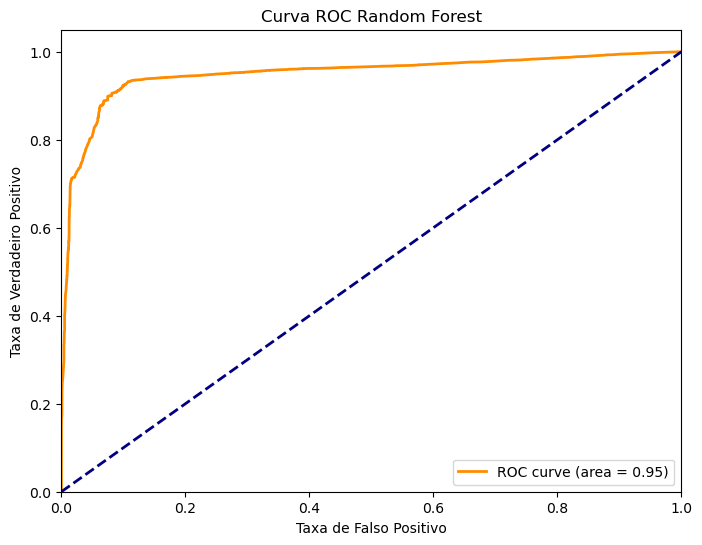

In [29]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50) 
best_params_rf = study_rf.best_params

pipeline_rf.set_params(**best_params_rf)
pipeline_rf.fit(X_train, y_train)

y_pred_rf = pipeline_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Acurácia do modelo Random Forest: {accuracy_rf:.2f}')

y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f'ROC-AUC do modelo Random Forest: {roc_auc_rf:.2f}')

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print('Matriz de Confusão Random Forest:')
print(conf_matrix_rf)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC Random Forest')
plt.legend(loc='lower right')
plt.show()

### XGBoost

In [30]:
import xgboost as xgb

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                                ('xgb', xgb.XGBClassifier())])

In [31]:
def objective_xgb(trial):
    params = {
        'xgb__n_estimators': trial.suggest_int('xgb__n_estimators', 50, 200),
        'xgb__max_depth': trial.suggest_int('xgb__max_depth', 3, 10),
        'xgb__learning_rate': trial.suggest_float('xgb__learning_rate', 0.01, 0.3),
        'xgb__subsample': trial.suggest_float('xgb__subsample', 0.6, 1.0),
        'xgb__colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.6, 1.0),
    }
    pipeline_xgb.set_params(**params)
    cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=5)
    return cv_scores.mean()

[I 2023-09-04 10:55:18,430] A new study created in memory with name: no-name-dd51dbfa-5f42-46aa-883d-0e3dfa1a288b
[I 2023-09-04 10:55:41,424] Trial 0 finished with value: 0.9416989567809239 and parameters: {'xgb__n_estimators': 106, 'xgb__max_depth': 9, 'xgb__learning_rate': 0.06350897650544718, 'xgb__subsample': 0.9305473633620215, 'xgb__colsample_bytree': 0.7899988371053346}. Best is trial 0 with value: 0.9416989567809239.
[I 2023-09-04 10:56:04,536] Trial 1 finished with value: 0.9412021857923497 and parameters: {'xgb__n_estimators': 155, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.28447440295247745, 'xgb__subsample': 0.9873413763532487, 'xgb__colsample_bytree': 0.771839592575815}. Best is trial 0 with value: 0.9416989567809239.
[I 2023-09-04 10:56:15,366] Trial 2 finished with value: 0.941818181818182 and parameters: {'xgb__n_estimators': 73, 'xgb__max_depth': 6, 'xgb__learning_rate': 0.19350768708612093, 'xgb__subsample': 0.9866950980057086, 'xgb__colsample_bytree': 0.82889556657

Acurácia do modelo XGBoost: 0.94
ROC-AUC do modelo XGBoost: 0.98
Matriz de Confusão XGBoost:
[[ 8935   484]
 [  754 11395]]


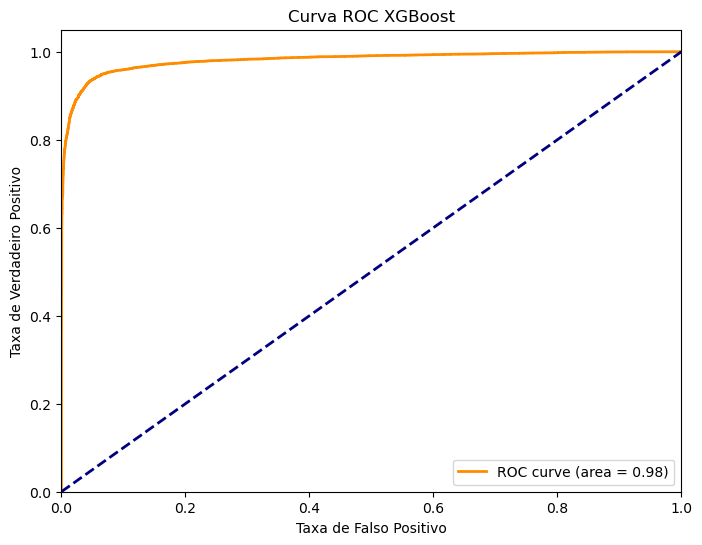

In [32]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50) 
best_params_xgb = study_xgb.best_params

pipeline_xgb.set_params(**best_params_xgb)
pipeline_xgb.fit(X_train, y_train)

y_pred_xgb = pipeline_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Acurácia do modelo XGBoost: {accuracy_xgb:.2f}')

y_prob_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f'ROC-AUC do modelo XGBoost: {roc_auc_xgb:.2f}')

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print('Matriz de Confusão XGBoost:')
print(conf_matrix_xgb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC XGBoost')
plt.legend(loc='lower right')
plt.show()

### LightGBM

In [33]:
import lightgbm as lgb

pipeline_lgbm = Pipeline(steps=[('preprocessor', preprocessor),
                                ('lgbm', lgb.LGBMClassifier())]) 

In [34]:
def objective_lgbm(trial):
    params = {
        'lgbm__n_estimators': trial.suggest_int('lgbm__n_estimators', 50, 200),
        'lgbm__max_depth': trial.suggest_int('lgbm__max_depth', 3, 10),
        'lgbm__learning_rate': trial.suggest_float('lgbm__learning_rate', 0.01, 0.3),
        'lgbm__subsample': trial.suggest_float('lgbm__subsample', 0.6, 1.0),
        'lgbm__colsample_bytree': trial.suggest_float('lgbm__colsample_bytree', 0.6, 1.0),
    }
    pipeline_lgbm.set_params(**params)
    cv_scores = cross_val_score(pipeline_lgbm, X_train, y_train, cv=5)
    return cv_scores.mean()

[I 2023-09-04 11:10:52,683] A new study created in memory with name: no-name-8e18a52a-3e35-4db8-9310-e18ca7400dd0


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:10:54,741] Trial 0 finished with value: 0.9409239940387482 and parameters: {'lgbm__n_estimators': 64, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.24057059810859663, 'lgbm__subsample': 0.7155137033689399, 'lgbm__colsample_bytree': 0.7082295822105987}. Best is trial 0 with value: 0.9409239940387482.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:10:57,274] Trial 1 finished with value: 0.9412419274714356 and parameters: {'lgbm__n_estimators': 110, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.274294986836586, 'lgbm__subsample': 0.7170643422865471, 'lgbm__colsample_bytree': 0.7226954381961932}. Best is trial 1 with value: 0.9412419274714356.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-09-04 11:11:00,113] Trial 2 finished with value: 0.940943864878291 and parameters: {'lgbm__n_estimators': 156, 'lgbm__max_depth': 4, 'lgbm__learning_rate': 0.18850127178430762, 'lgbm__subsample': 0.776150618900791, 'lgbm__colsample_bytree': 0.7584590702400512}. Best is trial 1 with value: 0.9412419274714356.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:11:03,745] Trial 3 finished with value: 0.9419970193740685 and parameters: {'lgbm__n_estimators': 166, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.07487680195902044, 'lgbm__subsample': 0.9936294934393506, 'lgbm__colsample_bytree': 0.7743417179970153}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-09-04 11:11:06,735] Trial 4 finished with value: 0.9386388474913065 and parameters: {'lgbm__n_estimators': 197, 'lgbm__max_depth': 3, 'lgbm__learning_rate': 0.06079071574307859, 'lgbm__subsample': 0.9458505888869896, 'lgbm__colsample_bytree': 0.9474527041603631}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-09-04 11:11:08,511] Trial 5 finished with value: 0.9408246398410333 and parameters: {'lgbm__n_estimators': 64, 'lgbm__max_depth': 4, 'lgbm__learning_rate': 0.2775095512717549, 'lgbm__subsample': 0.9931268077995018, 'lgbm__colsample_bytree': 0.9665463029719179}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2023-09-04 11:11:10,889] Trial 6 finished with value: 0.937645305514158 and parameters: {'lgbm__n_estimators': 116, 'lgbm__max_depth': 3, 'lgbm__learning_rate': 0.08432892700448162, 'lgbm__subsample': 0.6882835194785066, 'lgbm__colsample_bytree': 0.8192002932939224}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data

[I 2023-09-04 11:11:13,634] Trial 7 finished with value: 0.9404669647292598 and parameters: {'lgbm__n_estimators': 111, 'lgbm__max_depth': 6, 'lgbm__learning_rate': 0.05875966719451752, 'lgbm__subsample': 0.6285147881972106, 'lgbm__colsample_bytree': 0.846113901109897}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2023-09-04 11:11:17,305] Trial 8 finished with value: 0.9397516145057129 and parameters: {'lgbm__n_estimators': 163, 'lgbm__max_depth': 3, 'lgbm__learning_rate': 0.11713276413338818, 'lgbm__subsample': 0.9973322678046089, 'lgbm__colsample_bytree': 0.8233809436844226}. Best is trial 3 with value: 0.9419970193740685.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:11:20,854] Trial 9 finished with value: 0.9420765027322403 and parameters: {'lgbm__n_estimators': 160, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.18700868152551742, 'lgbm__subsample': 0.8334270891878391, 'lgbm__colsample_bytree': 0.9140804189796696}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you d

[I 2023-09-04 11:11:26,861] Trial 10 finished with value: 0.9384798807749627 and parameters: {'lgbm__n_estimators': 198, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.011560747158745444, 'lgbm__subsample': 0.8583451656947464, 'lgbm__colsample_bytree': 0.6080922078288736}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:11:30,482] Trial 11 finished with value: 0.941599602583209 and parameters: {'lgbm__n_estimators': 156, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.15536351022164852, 'lgbm__subsample': 0.8858038374528169, 'lgbm__colsample_bytree': 0.887019561044394}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:11:34,006] Trial 12 finished with value: 0.9412419274714356 and parameters: {'lgbm__n_estimators': 170, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.19455324647968222, 'lgbm__subsample': 0.8525731320430369, 'lgbm__colsample_bytree': 0.9045759381068765}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:11:37,125] Trial 13 finished with value: 0.9417188276204669 and parameters: {'lgbm__n_estimators': 133, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.1253456972319677, 'lgbm__subsample': 0.9207346216364188, 'lgbm__colsample_bytree': 0.8894753461208652}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:11:40,753] Trial 14 finished with value: 0.9414207650273223 and parameters: {'lgbm__n_estimators': 137, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.19175798424895701, 'lgbm__subsample': 0.8097953458493019, 'lgbm__colsample_bytree': 0.9760806634728458}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:11:44,678] Trial 15 finished with value: 0.9413214108296076 and parameters: {'lgbm__n_estimators': 183, 'lgbm__max_depth': 6, 'lgbm__learning_rate': 0.15069814222823313, 'lgbm__subsample': 0.9325031888179108, 'lgbm__colsample_bytree': 0.7854280995089886}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Wa

[I 2023-09-04 11:11:48,110] Trial 16 finished with value: 0.9417585692995528 and parameters: {'lgbm__n_estimators': 142, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.2226387383149233, 'lgbm__subsample': 0.8032632166363401, 'lgbm__colsample_bytree': 0.8590504841823728}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you d

[I 2023-09-04 11:11:51,266] Trial 17 finished with value: 0.9411823149528068 and parameters: {'lgbm__n_estimators': 89, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.10507419830779409, 'lgbm__subsample': 0.9692263473285643, 'lgbm__colsample_bytree': 0.9937204300712199}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:11:55,253] Trial 18 finished with value: 0.9415002483854943 and parameters: {'lgbm__n_estimators': 181, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.1468880374510348, 'lgbm__subsample': 0.8968535287998689, 'lgbm__colsample_bytree': 0.9216860050119927}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you d

[I 2023-09-04 11:12:00,019] Trial 19 finished with value: 0.9398708395429708 and parameters: {'lgbm__n_estimators': 150, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.015458846987009625, 'lgbm__subsample': 0.9572468126585871, 'lgbm__colsample_bytree': 0.9232511616690078}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:12:03,869] Trial 20 finished with value: 0.9409239940387482 and parameters: {'lgbm__n_estimators': 182, 'lgbm__max_depth': 5, 'lgbm__learning_rate': 0.08857226193875262, 'lgbm__subsample': 0.9076826557303713, 'lgbm__colsample_bytree': 0.8585921525392535}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:12:07,048] Trial 21 finished with value: 0.9412419274714356 and parameters: {'lgbm__n_estimators': 141, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.2265319555091677, 'lgbm__subsample': 0.8107160365125763, 'lgbm__colsample_bytree': 0.8572042065311999}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:12:10,255] Trial 22 finished with value: 0.9409836065573771 and parameters: {'lgbm__n_estimators': 125, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.22561042202510093, 'lgbm__subsample': 0.8517415031846906, 'lgbm__colsample_bytree': 0.799123397392091}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:12:14,767] Trial 23 finished with value: 0.9400695479384004 and parameters: {'lgbm__n_estimators': 169, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.29626943820229706, 'lgbm__subsample': 0.7726565135263385, 'lgbm__colsample_bytree': 0.9363800904106478}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:12:17,951] Trial 24 finished with value: 0.9420566318926975 and parameters: {'lgbm__n_estimators': 143, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.18028204227445022, 'lgbm__subsample': 0.875569176386518, 'lgbm__colsample_bytree': 0.879354076805156}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:12:20,312] Trial 25 finished with value: 0.9418976651763536 and parameters: {'lgbm__n_estimators': 95, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.17147207381815696, 'lgbm__subsample': 0.8852167227419102, 'lgbm__colsample_bytree': 0.8959689549369362}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:12:23,490] Trial 26 finished with value: 0.9413412816691504 and parameters: {'lgbm__n_estimators': 150, 'lgbm__max_depth': 6, 'lgbm__learning_rate': 0.13827030037403956, 'lgbm__subsample': 0.9666972089896729, 'lgbm__colsample_bytree': 0.9543732454716073}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:12:27,394] Trial 27 finished with value: 0.9412021857923497 and parameters: {'lgbm__n_estimators': 173, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.16109601696058623, 'lgbm__subsample': 0.93013209997452, 'lgbm__colsample_bytree': 0.8740969778643027}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:12:30,813] Trial 28 finished with value: 0.941679085941381 and parameters: {'lgbm__n_estimators': 125, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.1308607577767163, 'lgbm__subsample': 0.8679526515149496, 'lgbm__colsample_bytree': 0.9980834230006497}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:12:34,197] Trial 29 finished with value: 0.9417784401390958 and parameters: {'lgbm__n_estimators': 160, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.1709683453394277, 'lgbm__subsample': 0.8334673140864006, 'lgbm__colsample_bytree': 0.8317351822935308}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:12:35,825] Trial 30 finished with value: 0.9406259314456035 and parameters: {'lgbm__n_estimators': 57, 'lgbm__max_depth': 5, 'lgbm__learning_rate': 0.2104326682576432, 'lgbm__subsample': 0.9090613394314246, 'lgbm__colsample_bytree': 0.7740472410470489}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy ma

[I 2023-09-04 11:12:37,912] Trial 31 finished with value: 0.9413810233482364 and parameters: {'lgbm__n_estimators': 76, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.1794620326980769, 'lgbm__subsample': 0.8829855298222936, 'lgbm__colsample_bytree': 0.9053610780566671}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFro

[I 2023-09-04 11:12:40,273] Trial 32 finished with value: 0.9414207650273223 and parameters: {'lgbm__n_estimators': 96, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.169102905788716, 'lgbm__subsample': 0.8937347391581592, 'lgbm__colsample_bytree': 0.8855750202479361}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.

[I 2023-09-04 11:12:42,890] Trial 33 finished with value: 0.9408842523596622 and parameters: {'lgbm__n_estimators': 100, 'lgbm__max_depth': 5, 'lgbm__learning_rate': 0.202816245615624, 'lgbm__subsample': 0.9350023431013968, 'lgbm__colsample_bytree': 0.7520567424447707}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-09-04 11:12:46,626] Trial 34 finished with value: 0.94173869846001 and parameters: {'lgbm__n_estimators': 151, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.17967341458444475, 'lgbm__subsample': 0.8307336173180006, 'lgbm__colsample_bytree': 0.9311797178322831}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train

[I 2023-09-04 11:12:48,859] Trial 35 finished with value: 0.9413015399900647 and parameters: {'lgbm__n_estimators': 84, 'lgbm__max_depth': 6, 'lgbm__learning_rate': 0.25503535782411224, 'lgbm__subsample': 0.8726130313321594, 'lgbm__colsample_bytree': 0.8096222477261124}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accu

[I 2023-09-04 11:12:51,838] Trial 36 finished with value: 0.9414207650273223 and parameters: {'lgbm__n_estimators': 131, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.1851208844022654, 'lgbm__subsample': 0.9771501726996016, 'lgbm__colsample_bytree': 0.8324629239511225}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFro

[I 2023-09-04 11:12:55,737] Trial 37 finished with value: 0.9415201192250372 and parameters: {'lgbm__n_estimators': 189, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.168067611437702, 'lgbm__subsample': 0.943435614944025, 'lgbm__colsample_bytree': 0.9592636168732731}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy ma

[I 2023-09-04 11:12:58,797] Trial 38 finished with value: 0.9411624441132638 and parameters: {'lgbm__n_estimators': 117, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.20755800447132236, 'lgbm__subsample': 0.9973360545744065, 'lgbm__colsample_bytree': 0.9040183459518164}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2023-09-04 11:13:01,129] Trial 39 finished with value: 0.9392747143566815 and parameters: {'lgbm__n_estimators': 71, 'lgbm__max_depth': 4, 'lgbm__learning_rate': 0.14207756806820807, 'lgbm__subsample': 0.9489224895719851, 'lgbm__colsample_bytree': 0.8386583692104205}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

[I 2023-09-04 11:13:05,745] Trial 40 finished with value: 0.9418579234972679 and parameters: {'lgbm__n_estimators': 164, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.1598650361377041, 'lgbm__subsample': 0.9086193947930125, 'lgbm__colsample_bytree': 0.8728140300926158}. Best is trial 9 with value: 0.9420765027322403.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:10,703] Trial 41 finished with value: 0.9423348236462991 and parameters: {'lgbm__n_estimators': 166, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.15663222993438017, 'lgbm__subsample': 0.9145035273261696, 'lgbm__colsample_bytree': 0.8726554210611243}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:15,377] Trial 42 finished with value: 0.9417188276204669 and parameters: {'lgbm__n_estimators': 174, 'lgbm__max_depth': 7, 'lgbm__learning_rate': 0.14613175751790106, 'lgbm__subsample': 0.8938701506858358, 'lgbm__colsample_bytree': 0.8122198399307292}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy ma

[I 2023-09-04 11:13:19,742] Trial 43 finished with value: 0.9414605067064084 and parameters: {'lgbm__n_estimators': 156, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.1907104672369247, 'lgbm__subsample': 0.9841645269045026, 'lgbm__colsample_bytree': 0.9445794552753783}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start traini

[I 2023-09-04 11:13:22,956] Trial 44 finished with value: 0.9415399900645802 and parameters: {'lgbm__n_estimators': 146, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.12738718528405402, 'lgbm__subsample': 0.8682234019892237, 'lgbm__colsample_bytree': 0.9067120965542275}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:26,431] Trial 45 finished with value: 0.9417784401390958 and parameters: {'lgbm__n_estimators': 193, 'lgbm__max_depth': 8, 'lgbm__learning_rate': 0.17896593579522038, 'lgbm__subsample': 0.9194992818712628, 'lgbm__colsample_bytree': 0.8427513167666987}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:30,021] Trial 46 finished with value: 0.9420765027322403 and parameters: {'lgbm__n_estimators': 164, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.11312829302352806, 'lgbm__subsample': 0.9521377083604314, 'lgbm__colsample_bytree': 0.8775221439947443}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:34,545] Trial 47 finished with value: 0.9419771485345254 and parameters: {'lgbm__n_estimators': 165, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.11214806810262565, 'lgbm__subsample': 0.9560354009937125, 'lgbm__colsample_bytree': 0.8697191311826347}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] No further splits with positive

[I 2023-09-04 11:13:38,872] Trial 48 finished with value: 0.9417784401390958 and parameters: {'lgbm__n_estimators': 177, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.10505108011773194, 'lgbm__subsample': 0.9824122637527268, 'lgbm__colsample_bytree': 0.8492957076376494}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 22320, number of negative: 17940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 40260, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554396 -> initscore=0.218450
[LightGBM] [Info] Start training from score 0.218450
[LightGBM] [Warning] Accuracy may be bad since you d

[I 2023-09-04 11:13:42,263] Trial 49 finished with value: 0.9416989567809239 and parameters: {'lgbm__n_estimators': 160, 'lgbm__max_depth': 9, 'lgbm__learning_rate': 0.06921736602630005, 'lgbm__subsample': 0.9658703804274891, 'lgbm__colsample_bytree': 0.8797127997029079}. Best is trial 41 with value: 0.9423348236462991.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27901, number of negative: 22424
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 940
[LightGBM] [Info] Number of data points in the train set: 50325, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554416 -> initscore=0.218531
[LightGBM] [Info] Start training from score 0.218531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

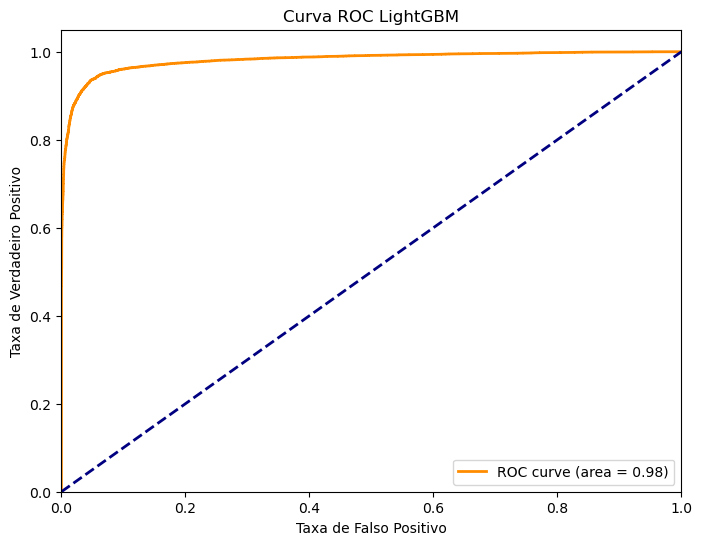

In [35]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=50) 
best_params_lgbm = study_lgbm.best_params

pipeline_lgbm.set_params(**best_params_lgbm)
pipeline_lgbm.fit(X_train, y_train)

y_pred_lgbm = pipeline_lgbm.predict(X_test)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f'Acurácia do modelo LightGBM: {accuracy_lgbm:.2f}')

y_prob_lgbm = pipeline_lgbm.predict_proba(X_test)[:, 1]
roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
print(f'ROC-AUC do modelo LightGBM: {roc_auc_lgbm:.2f}')

conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print('Matriz de Confusão LightGBM:')
print(conf_matrix_lgbm)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_lgbm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC LightGBM')
plt.legend(loc='lower right')
plt.show()

## EVALUATION

In [36]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score

# Calcular acurácia
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_lg = accuracy_score(y_test, y_pred_lg)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

# Calcular AUC
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
roc_auc_lg = roc_auc_score(y_test, y_prob_lg)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
roc_auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)

# Calcular sensibilidade (recall)
recall_rf = recall_score(y_test, y_pred_rf)
recall_lg = recall_score(y_test, y_pred_lg)
recall_xgb = recall_score(y_test, y_pred_xgb)
recall_lgbm = recall_score(y_test, y_pred_lgbm)

# Calcular pontuação F1
f1_score_rf = f1_score(y_test, y_pred_rf)
f1_score_lg = f1_score(y_test, y_pred_lg)
f1_score_xgb = f1_score(y_test, y_pred_xgb)
f1_score_lgbm = f1_score(y_test, y_pred_lgbm)

In [37]:
metrics_dict = {
    'Modelo': ['Random Forest', 'Logistic Regression', 'XGBoost', 'LightGBM'],
    'Acurácia': [accuracy_rf, accuracy_lg, accuracy_xgb, accuracy_lgbm],
    'AUC': [roc_auc_rf, roc_auc_lg, roc_auc_xgb, roc_auc_lgbm],
    'Sensibilidade': [recall_rf, recall_lg, recall_xgb, recall_lgbm],
    'F1 Score': [f1_score_rf, f1_score_lg, f1_score_xgb, f1_score_lgbm]
}

df_metrics = pd.DataFrame(metrics_dict)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

styled_df = df_metrics.style.apply(highlight_max, subset=['Acurácia', 'AUC', 'Sensibilidade', 'F1 Score'], axis=0)
styled_df

,Modelo,Acurácia,AUC,Sensibilidade,F1 Score
0,Random Forest,0.911257,0.949664,0.935715,0.922353
1,Logistic Regression,0.923776,0.958071,0.909211,0.930738
2,XGBoost,0.942600,0.981308,0.937937,0.948477
3,LightGBM,0.942554,0.981449,0.938267,0.948454


Como o modelo não possui um grande desbalanceamento das classes, podemos utilizar a **AUC** como uma boa métrica.
Avaliando o desempenho nas métricas escolhidas para avaliação, consideramos como melhor modelo o **XGBoost**.